In [95]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split ,StratifiedKFold , cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from category_encoders import *
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve


from sklearn.metrics import accuracy_score, classification_report 


In [3]:
df = pd.read_excel('/kaggle/input/customer-churn/customer_churn_large_dataset.xlsx')

In [4]:
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   CustomerID                  100000 non-null  int64  
 1   Name                        100000 non-null  object 
 2   Age                         100000 non-null  int64  
 3   Gender                      100000 non-null  object 
 4   Location                    100000 non-null  object 
 5   Subscription_Length_Months  100000 non-null  int64  
 6   Monthly_Bill                100000 non-null  float64
 7   Total_Usage_GB              100000 non-null  int64  
 8   Churn                       100000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 6.9+ MB


In [6]:
df.describe()

,CustomerID,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,50000.500000,44.027020,12.490100,65.053197,274.393650,0.497790
std,28867.657797,15.280283,6.926461,20.230696,130.463063,0.499998
min,1.000000,18.000000,1.000000,30.000000,50.000000,0.000000
25%,25000.750000,31.000000,6.000000,47.540000,161.000000,0.000000
50%,50000.500000,44.000000,12.000000,65.010000,274.000000,0.000000
75%,75000.250000,57.000000,19.000000,82.640000,387.000000,1.000000
max,100000.000000,70.000000,24.000000,100.000000,500.000000,1.000000


In [7]:
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

In [8]:
df = df.drop(['CustomerID','Name'],axis=1)
df.head()

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0
2,24,Female,Los Angeles,5,85.47,460,0
3,36,Female,Miami,3,97.94,297,1
4,46,Female,Miami,19,58.14,266,0


### Check for null Values

In [9]:
df.isna().sum()

Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

### Summary Statistics for continous features

In [10]:
continous_feat = df.columns[df.nunique()  > 20]
df[continous_feat].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,100000.0,44.027020,15.280283,18.0,31.00,44.00,57.00,70.0
Subscription_Length_Months,100000.0,12.490100,6.926461,1.0,6.00,12.00,19.00,24.0
Monthly_Bill,100000.0,65.053197,20.230696,30.0,47.54,65.01,82.64,100.0
Total_Usage_GB,100000.0,274.393650,130.463063,50.0,161.00,274.00,387.00,500.0


In [98]:
# List of categorical columns
categorical_columns = ['Gender', 'Location', 'Churn']

# Calculate the number of unique values for each categorical column
unique_counts = df[categorical_columns].nunique()
unique_counts

Gender      2
Location    5
Churn       2
dtype: int64

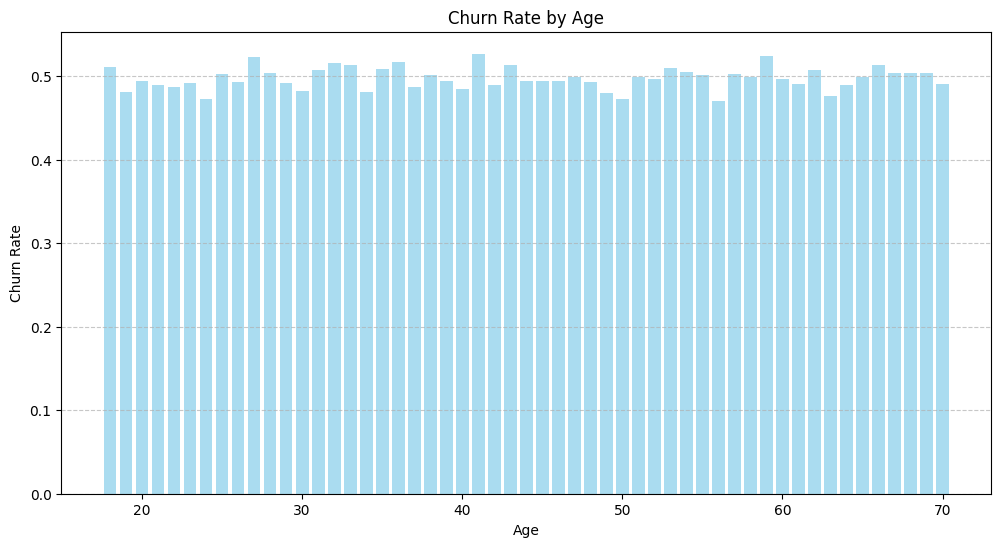

In [15]:
# Group the data by 'Age' and calculate the Churn rate (mean of Churn column) for each age group
age_churn = df.groupby('Age')['Churn'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(age_churn['Age'], age_churn['Churn'], color='skyblue', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Age')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

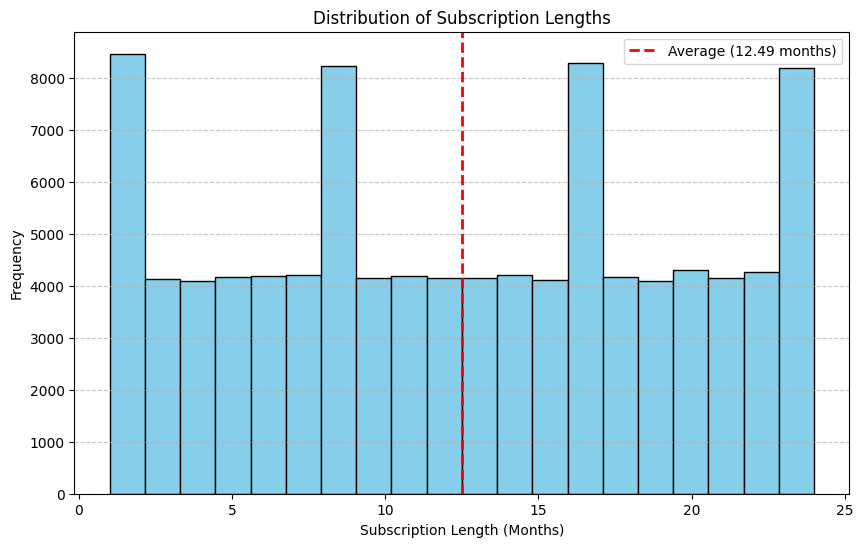

The average subscription length is 12.49 months.


In [16]:
# Calculate the average subscription length
average_subscription_length = df['Subscription_Length_Months'].mean()

# plot histogram 
plt.figure(figsize=(10, 6))
plt.hist(df['Subscription_Length_Months'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Subscription Length (Months)')
plt.ylabel('Frequency')
plt.title('Distribution of Subscription Lengths')
plt.axvline(average_subscription_length, color='red', linestyle='dashed', linewidth=2, label=f'Average ({average_subscription_length:.2f} months)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print(f"The average subscription length is {average_subscription_length:.2f} months.")

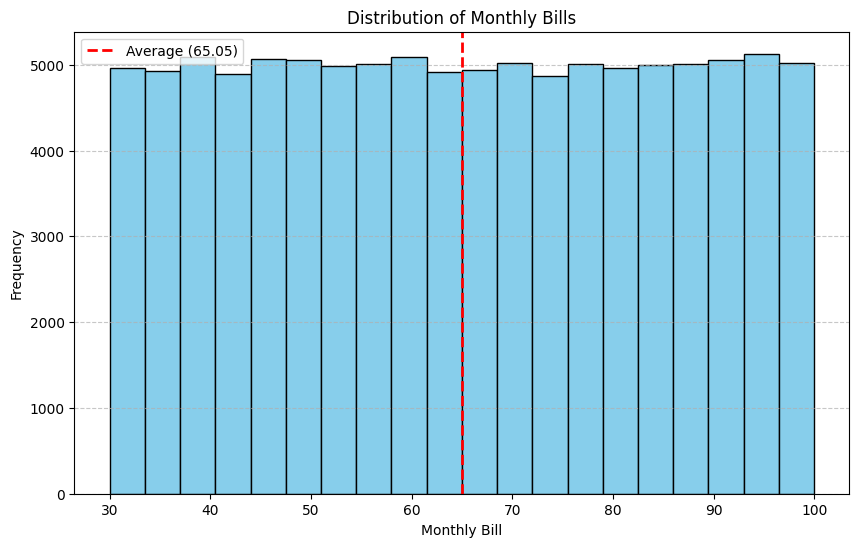

The average monthly bill is $65.05.


In [17]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculate the average monthly bill
average_monthly_bill = df['Monthly_Bill'].mean()

plt.figure(figsize=(10, 6))
plt.hist(df['Monthly_Bill'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Monthly Bill')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Bills')
plt.axvline(average_monthly_bill, color='red', linestyle='dashed', linewidth=2, label=f'Average ({average_monthly_bill:.2f})')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print(f"The average monthly bill is ${average_monthly_bill:.2f}.")


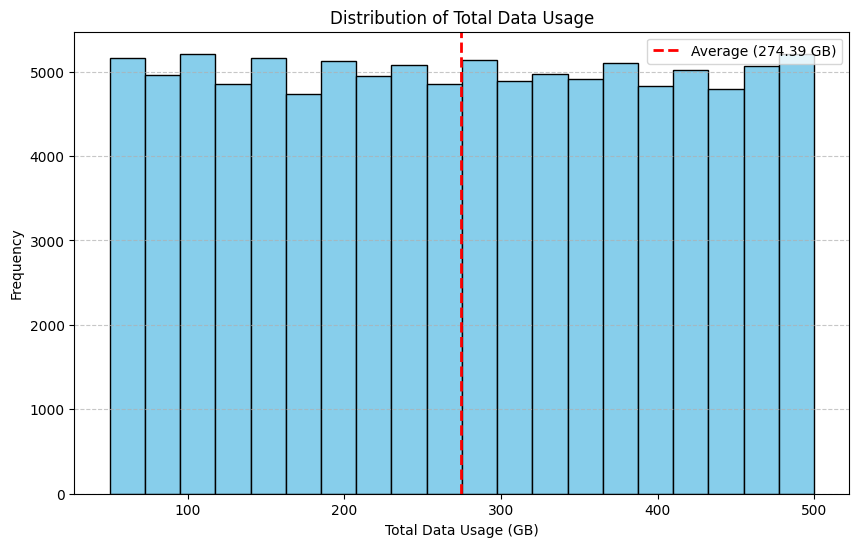

The average total data usage is 274.39 GB.


In [18]:
# Calculate the average total data usage
average_total_usage = df['Total_Usage_GB'].mean()

# Create a histogram to visualize the distribution of total data usage
plt.figure(figsize=(10, 6))
plt.hist(df['Total_Usage_GB'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Data Usage (GB)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Data Usage')
plt.axvline(average_total_usage, color='red', linestyle='dashed', linewidth=2, label=f'Average ({average_total_usage:.2f} GB)')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display the average total data usage
print(f"The average total data usage is {average_total_usage:.2f} GB.")

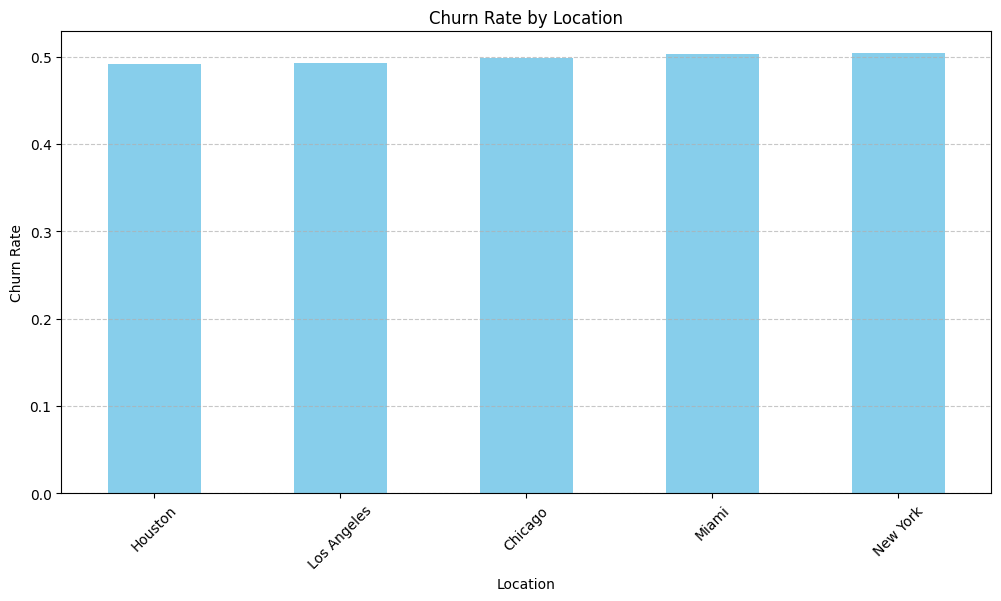

In [19]:
# Calculate the Churn rate for each location
location_churn_rate = df.groupby('Location')['Churn'].mean().sort_values()

# Create a bar plot to visualize the Churn rates by location
plt.figure(figsize=(12, 6))
location_churn_rate.plot(kind='bar', color='skyblue')
plt.xlabel('Location')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Location')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# df1=df.drop(['CustomerID','Name'],axis=1)


### Feature Engineering (Data Preprocessing,Encoding,Splitting)

In [25]:
def feature_engineering(data):
        
    #  One-Hot Encoding for Gender
    data = pd.get_dummies(data, columns=['Gender'], drop_first=True)

    #  Billing per Usage
    data['Billing_Per_Usage'] = data['Monthly_Bill'] / data['Total_Usage_GB']

    #  Tenure
    max_subscription_length = data['Subscription_Length_Months'].max()
    data['Tenure'] = max_subscription_length - data['Subscription_Length_Months']
    
    # Split the data into training and testing sets
    X = data.drop(columns=['Churn'])  # Features
    y = data['Churn']  # Target variable
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    encoder = TargetEncoder()
    X_train['Location'] = encoder.fit_transform(X_train['Location'], y_train)
    X_test['Location'] = encoder.transform(X_test['Location'])
    
    numerical_columns = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB','Tenure','Billing_Per_Usage','Location']
    scaler = StandardScaler()
    X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
    X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
    
    joblib.dump(encoder, 'target_encoder.pkl')
    joblib.dump(scaler,'scaler.pkl')
    
    return X_train, X_test, y_train, y_test



In [85]:
X_train, X_test, y_train, y_test = feature_engineering(df)

print(f'Training Data shape : {X_train.shape}')
print(f'Testing Data shape : {X_test.shape}')

Training Data shape : (80000, 8)
Testing Data shape : (20000, 8)


Text(0.5, 1.0, 'Correlation Heatmap')

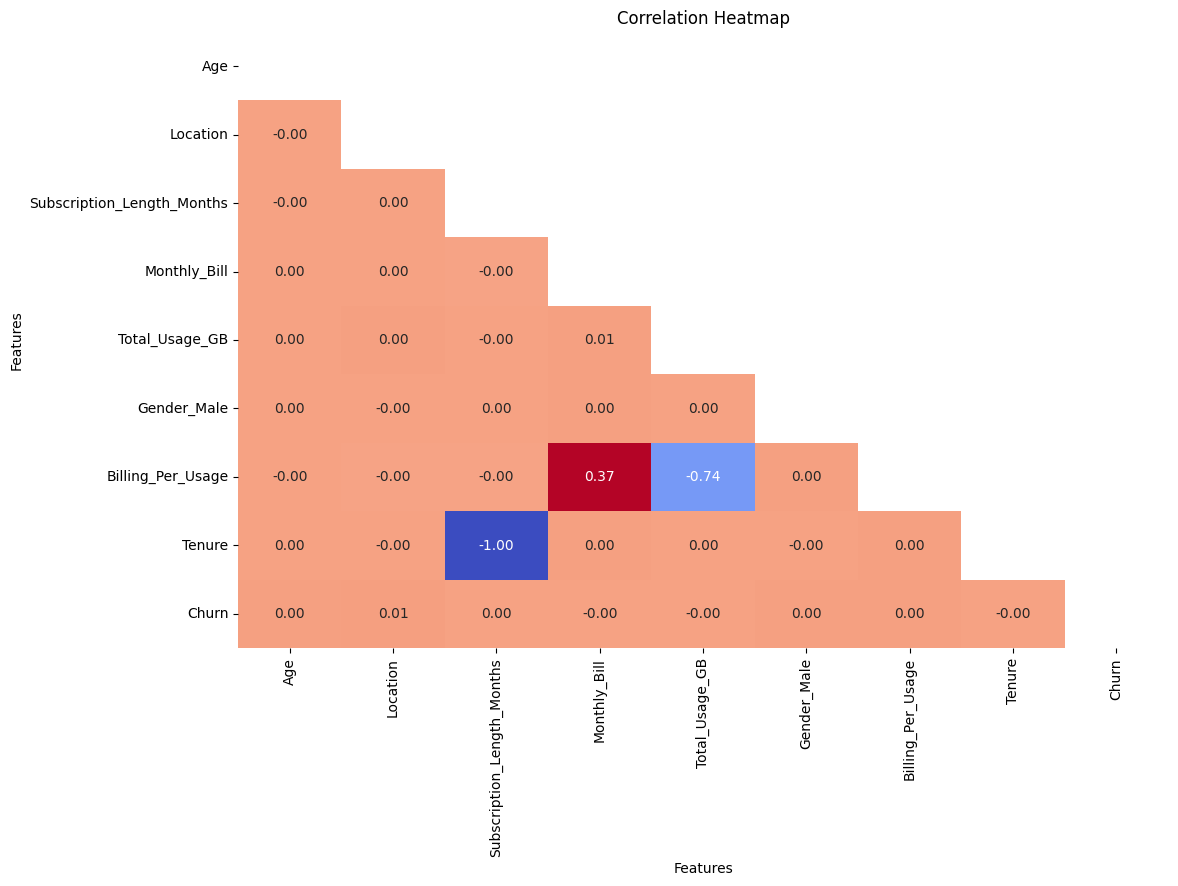

In [90]:
data = pd.concat([X_train, y_train], axis=1)

# Create a correlation matrix
corr_matrix = data.corr()

# Create a mask to hide the upper triangle (redundant information)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the figure and plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, fmt=".2f", mask=mask, cmap="coolwarm", cbar=False)

# Add labels and title
plt.xlabel("Features")
plt.ylabel("Features")
plt.title("Correlation Heatmap")


There is zero correlation between Target Variable 'Churn' and other Independent Variables

#### Stratified K-fold Cross Validation And Grid Search CV ( Hyperparameter Tuning )

In [79]:
from sklearn.model_selection import RandomizedSearchCV

# Define a range of hyperparameters to search
from scipy.stats import uniform

param_dist = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization type
    'C': uniform(loc=0, scale=4),  # Inverse of regularization strength (a continuous distribution)
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Optimization algorithm
    'max_iter': [100, 200, 300, 400, 500]  # Maximum number of iterations for the solver
}

# Create a Random Forest model
lr_model = LogisticRegression(random_state=42)

# Create a grid search with cross-validation
randomized_search = RandomizedSearchCV(estimator=lr_model, param_distributions=param_grid, cv=kfold, scoring='accuracy', n_iter=50, random_state=42)

# Perform the grid search on small sample data
grid_search.fit(X_train[:4000], y_train[:4000])

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


In [81]:
# Get the best model
best_model = grid_search.best_estimator_

# Train on full train data
best_model.fit(X_train,y_train)
# Make predictions on the test data using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Test Accuracy with Best Model: {accuracy:.2f}")
print("Test Classification Report with Best Model:\n", report)

Test Accuracy with Best Model: 0.50
Test Classification Report with Best Model:
               precision    recall  f1-score   support

           0       0.50      0.58      0.54     10079
           1       0.49      0.41      0.45      9921

    accuracy                           0.50     20000
   macro avg       0.50      0.50      0.49     20000
weighted avg       0.50      0.50      0.49     20000



In [84]:
# Save the  best model 
joblib.dump(best_model, 'best_model.pkl')


['best_model.pkl']

### Precision Recall Curve

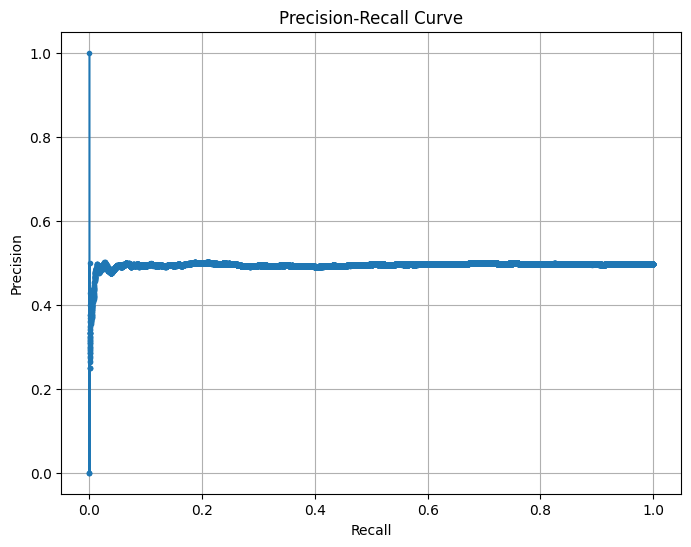

In [96]:
# Get predicted probabilities for positive class (Churn)
y_scores = best_model.predict_proba(X_test)[:, 1]

# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()